## ACTD 2024 - 20

### Clases 13-14: redes neuronales para clasificación

- Redes densas
- Redes para clasificación
- Procesamiento de datos continuos y categóricos
- Funciones de activación y pérdida

Empecemos importando numpy, pandas, keras, tensorflow

In [38]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


Carguemos el archivo auto-mpg.data (disponible en Bloque Neón) usando pandas. Note que debemos incluir los nombres de las columnas, además de indicar los caracteres para separación, nas y comentarios.

In [39]:
df = pd.read_csv('heart.csv')

Exploremos las primeras filas del dataframe.

In [40]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


Descripción de las variables:

https://archive.ics.uci.edu/dataset/45/heart+disease


Exploremos el tamaño del df

In [41]:
df.shape

(303, 14)

Identificamos NAs en los datos

In [42]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Definimos listas para las variables categóricas enteras, categóricas string y numéricas.

In [43]:
subset_feats = ['age', 'trestbps', 'chol', 'sex', 'cp']
df = df[subset_feats+['target']]


In [44]:
df.head()

,age,trestbps,chol,sex,cp,target
0,63,145,233,1,1,0
1,67,160,286,1,4,1
2,67,120,229,1,4,0
3,37,130,250,1,3,0
4,41,130,204,0,2,0


Separamos los datos en entrenamiento, validación y prueba

In [45]:
train = df.sample(frac=0.8, random_state=100)
train.head()

,age,trestbps,chol,sex,cp,target
69,35,138,183,0,4,0
300,65,135,254,1,4,1
220,59,134,204,1,1,0
134,42,120,240,1,3,0
7,57,120,354,0,4,0


In [46]:
train.shape

(242, 6)

In [47]:
test = df.drop(train.index)
test.head()

,age,trestbps,chol,sex,cp,target
0,63,145,233,1,1,0
2,67,120,229,1,4,0
4,41,130,204,0,2,0
8,63,130,254,1,4,1
13,44,120,263,1,2,0


In [48]:
val = train.sample(frac=0.2, random_state=100)

In [49]:
val.shape

(48, 6)

In [50]:
train = train.drop(val.index)

In [51]:
print(train.shape)
print(val.shape)
print(test.shape)

(194, 6)
(48, 6)
(61, 6)


Calculamos estadísticas de cada variable numérica

In [52]:
train.describe()

,age,trestbps,chol,sex,cp,target
count,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000
mean,54.953608,132.876289,249.974227,0.664948,3.097938,0.257732
std,8.754150,17.952879,52.803226,0.473230,1.030969,0.438517
min,34.000000,94.000000,126.000000,0.000000,0.000000,0.000000
25%,49.000000,120.000000,215.750000,0.000000,2.000000,0.000000
50%,56.000000,130.000000,243.000000,1.000000,3.000000,0.000000
75%,61.000000,143.500000,281.000000,1.000000,4.000000,1.000000
max,77.000000,192.000000,564.000000,1.000000,4.000000,1.000000


Función para convertir de dataframe (pandas) a dataset (tensorflow), separando características y etiquetas

In [53]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

In [54]:
train_ds = dataframe_to_dataset(train)
val_ds = dataframe_to_dataset(val)
test_ds = dataframe_to_dataset(test)

In [55]:
type(train_ds)

tensorflow.python.data.ops.shuffle_op._ShuffleDataset

Ejemplo de cómo queda el tf.dataset

In [56]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'age': <tf.Tensor: shape=(), dtype=int64, numpy=51>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=100>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=222>, 'sex': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'cp': <tf.Tensor: shape=(), dtype=int64, numpy=3>}
Target: tf.Tensor(0, shape=(), dtype=int64)


Separamos los datos de entrenamiento, validación y prueba en lotes

In [57]:
batch_size = 32
train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Función para codificar variables numéricas (Keras docs)

In [58]:
def encode_numerical_feature(feature, name, dataset):
    # Crea capa de normalización para este feature
    normalizer = keras.layers.Normalization()

    # Prepara el dataset para considerar únicamente la feature de interés (name)
    feature_ds = dataset.map(lambda x, y: x[name]) # selecciona variable
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1)) # deja el tensor de una dimensión

    # Aprende las estadísticas de los datos (media, varianza)
    normalizer.adapt(feature_ds)

    # Aplica la normalización a la variable
    encoded_feature = normalizer(feature)
    return encoded_feature

Función para codificar variables categóricas (Keras docs)

In [59]:
def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = keras.layers.StringLookup if is_string else keras.layers.IntegerLookup
    # Crea una capa Lookup para retornas variables 0/1 (dummies)
    # lookup: busca el valor correspondiente de la variable categórica
    lookup = lookup_class(output_mode="binary")

    # Prepara el dataset para considerar únicamente la feature de interés (name)
    feature_ds = dataset.map(lambda x, y: x[name]) # selecciona variable
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1)) # deja el tensor de una dimensión

    # Aprende el conjunto de posibles valores que toma la variable categórica y asigna enteros
    lookup.adapt(feature_ds)

    # Aplica la conversión de categorías a enteros
    encoded_feature = lookup(feature)
    return encoded_feature

Creamos una lista de inputs para el modelo, de acuerdo con cada tipo de variable

In [60]:
inputs = {
    'age': keras.Input(shape=(1,), name='age'),
    'trestbps': keras.Input(shape=(1,), name='trestbps'),
    'chol': keras.Input(shape=(1,), name='chol'),
    'sex': keras.Input(shape=(1,), name='sex', dtype='int64'),
    'cp': keras.Input(shape=(1,), name='cp', dtype='int64')
}

In [61]:
for i in inputs:
   print(i)

age
trestbps
chol
sex
cp


Creamos una lista de variables codificadas/normalizadas de acuerdo con su tipo, empleando las funciones de codificación/normalización

In [62]:
feats_encoded = [
    encode_numerical_feature(inputs['age'], 'age', train_ds),
    encode_numerical_feature(inputs['trestbps'], 'trestbps', train_ds),
    encode_numerical_feature(inputs['chol'], 'chol', train_ds),
    encode_categorical_feature(inputs['sex'], 'sex', train_ds, False),  # 'sex' es categórica (entero)
    encode_categorical_feature(inputs['cp'], 'cp', train_ds, False)  # 'cp' es categórica (entero)
]

In [63]:
len_feats = len(feats_encoded)
len_feats

5

In [64]:
for i in feats_encoded:
  print(i)

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_8>
<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_9>
<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_10>
<KerasTensor shape=(None, 3), dtype=float32, sparse=False, name=keras_tensor_11>
<KerasTensor shape=(None, 6), dtype=float32, sparse=False, name=keras_tensor_12>


Creamos una capa concatenando todas las variables codificadas

In [65]:
all_feats = keras.layers.concatenate(feats_encoded)

In [66]:
type(all_feats)

keras.src.backend.common.keras_tensor.KerasTensor

Agregamos una capa densa con 32 neuronas y función de activación relu

In [67]:
model_layers = keras.layers.Dense(32, activation='relu')(all_feats)

Agregamos la capa de salida con 1 neurona (probabilidad de sufrir la enfermedad cardiada) y función de activación sigmoide

In [68]:
model_layers = keras.layers.Dense(1, activation='sigmoid')(model_layers)

Creamos el modelo con las capas ya creadas y las variables de entrada

In [69]:
model = keras.Model(inputs, model_layers)

Compilamos el modelo, definiendo optimizador, función de pérdida y métricas adicionales a capturar

In [70]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [71]:
#keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

Aseguramos que Keras use TensorFlow como backend, para asegurar que el modelo pueda usar strings como entradas

In [72]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

Entrenamos el modelo con los datos en el formato tf.Dataset

In [73]:
history=model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5399 - loss: 0.6931 - val_accuracy: 0.6250 - val_loss: 0.6561
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6244 - loss: 0.6797 - val_accuracy: 0.6667 - val_loss: 0.6378
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6953 - loss: 0.6651 - val_accuracy: 0.7083 - val_loss: 0.6220
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7137 - loss: 0.6467 - val_accuracy: 0.7292 - val_loss: 0.6077
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7115 - loss: 0.6471 - val_accuracy: 0.7500 - val_loss: 0.5944
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7529 - loss: 0.6141 - val_accuracy: 0.7500 - val_loss: 0.5831
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7298 - loss: 0.6127 - val_accuracy: 0.7500 - val_loss: 0.5765
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7377 - loss: 0.5983 - val_accuracy: 0.7500 - val_loss: 0.5686
Epoch 9

Graficar la pérdida de entrenamiento y validación

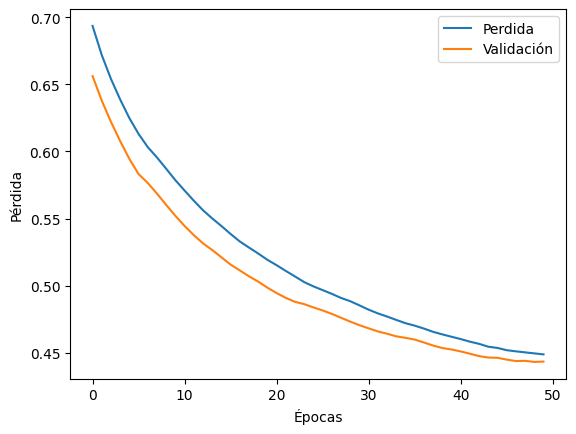

In [74]:
plt.plot(history.history['loss'], label='Perdida')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


Hacer predicciones en el set de prueba

In [75]:

y_true = []
y_pred = []
for x, y in test_ds:
    y_true.extend(list(y.numpy()))
    y_pred.extend(list(model.predict(x).flatten()))

# Convertir las predicciones a binario (0 o 1)
y_pred_bin = [1 if pred >= 0.5 else 0 for pred in y_pred]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Calcular las métricas

In [76]:
accuracy = accuracy_score(y_true, y_pred_bin)
precision = precision_score(y_true, y_pred_bin)
recall = recall_score(y_true, y_pred_bin)
f1 = f1_score(y_true, y_pred_bin)

# Imprimir las métricas
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

Accuracy: 0.7049180327868853
Precision: 0.6666666666666666
Recall: 0.2857142857142857
F1-score: 0.4
